In [1]:
import numpy as np

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import cm

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

from astroML.classification import GMMBayes
from astroML.datasets import fetch_rrlyrae_combined
from astroML.utils import split_samples

from scipy.stats import norm


from astropy.io import ascii
from astropy.io import fits
import os.path

from astropy.table import Table, join, MaskedColumn, vstack, Column

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

print(tf.__version__)

from sklearn.metrics import ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.gaussian_process import GaussianProcessRegressor

from tqdm import tqdm

2024-06-04 16:16:38.010698: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.16.1


In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [4]:
mpl.rcParams['figure.dpi'] = 150
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('legend', fontsize='x-small')
cmap = cm.get_cmap('viridis')

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2837194893.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


In [5]:
data=Table.read('Stats_Table_For_Data_augmented_lcs_v2.fits')

data

sector_stitched=Table.read('Stats_Table_For_Sector_Stitched.fits')

data = vstack([data, sector_stitched])

data

name,Lit_Clst_Age,rms,std,MAD,sigmaG,skewness,von_neumann_ratio,J_Stetson,max_power,freq_at_max_power,n_peaks,ratio_of_power_at_high_v_low_freq,FAP,max_autocorrelation,time_of_max_autocorrelation,SumLSP_10_7_Day_Power,SumLSP_7_4_Day_Power,SumLSP_4_1_Day_Power,SumLSP_1_p5_Day_Power,Entropy
bytes17,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64[1],float64,float64,float64,float64,float64
NGC 5381,8.65,0.2022739754519168,0.00028663242586913503,0.00018204904335616945,0.00027032716740019386,-5.109964804222913e-12,0.00386747638646434,11.012043362402764,0.2956196136312983,2.1800000000000006,7,35.25172608498783,5.6489191125891904e-83,0.6090280071896582,0.5000039539129375,0.08840027872050202,0.551564524378355,1.1235926764590056,0.2938252007400544,0.00912773133976864
NGC 5381,8.65,0.12860581353173967,0.00029758624459087497,0.00018677990032528458,0.0002724429021247358,-1.4861178185896828e-11,0.0072174287439932296,11.19932586798964,0.2858757168806013,2.1800000000000006,2,22.58421369093873,3.1991008561289327e-38,0.35192202026737984,0.5000117633198897,0.08236173981181749,0.8858419453379427,2.1146489663557895,0.6387350704087281,0.009878216867509258
NGC 5381,8.65,0.2022739754519168,0.0002749497473011351,0.0001760566489865667,0.0002598061826987392,4.985244439169258e-12,0.008432348981660785,10.832836728495531,0.3321170484680969,2.1800000000000006,2,63.9392138272648,1.7081151810643954e-46,0.6090280071896582,0.5000039539129375,0.24075422793919207,1.6594671516063568,2.1257999401516057,0.448080689756279,-0.0007504855277406172
NGC 5381,8.65,0.13418989839761541,0.00029670974388146205,0.00018715823279225052,0.00027474567848145,-1.4819021191571437e-11,0.007902359972537888,11.215158743038272,0.3092047888317955,2.1900000000000004,2,22.086456566940438,3.976387179616506e-37,0.35367954438974186,0.4791779375589158,0.09887134140967274,1.1529494497686852,2.490978861040854,0.6349831324113722,0.006366704374634439
NGC 5381,8.65,0.17262428678829597,0.0002957994551170428,0.0001947926770065056,0.00028877667424492826,7.949348591748663e-12,0.007853282537324254,11.344726858798873,0.2823310089408097,2.1800000000000006,3,25.45485685062133,5.270363097162563e-33,0.44152498501025716,0.6875159881769832,0.06948436182961143,0.8943645304859869,2.617654265447661,0.8130747500049615,0.002130485780783362
NGC 5381,8.65,0.20342537128083304,0.0002732158088483212,0.00017971636228852894,0.0002662374500090785,4.074129139791262e-12,0.007349842456913631,10.283775613193056,0.3538975416671665,2.1800000000000006,4,36.69742716441359,2.390364865023084e-44,0.5316360879383262,0.43750944667317526,0.0949982493524582,0.4623089900428734,2.053662679896389,1.046635427882411,0.0028261693332049306
NGC 5381,8.65,0.2307399119235911,0.0002677956171043393,0.00018059586669483263,0.0002665594344778601,4.8205018650938374e-12,0.007782358681751355,10.123885193997234,0.3386046778402443,2.1900000000000004,6,44.498114854025175,9.393056151242283e-42,0.47518645396899706,0.4375085258229774,0.05300589586641587,0.29486004971296664,2.174814315902417,1.095353559280317,-0.0043037936123419135
NGC 5381,8.65,0.22077649622315093,0.00028736928263985265,0.00019529854088140564,0.0002865572846073615,3.3188360954961803e-12,0.008793630554351822,10.922918396661096,0.27925708595394183,2.1900000000000004,6,52.40948815416692,2.0673842635311304e-32,0.6002905113611597,0.5000039539129375,0.24813217870249696,1.2957295189420075,2.28049676322127,0.8465257783128015,0.007883061859175302
NGC 5381,8.65,0.21821100221255357,0.0002979377559200514,0.0002010363813400584,0.00029422255247299917,3.048307924578792e-12,0.00967834794471458,11.503733919463457,0.29776047325346133,0.22000000000000006,3,61.22050634304591,2.696162426828419e-35,0.60816054645364,0.5000039539129375,0.32120520102402084,2.126809469890936,2.186733635251189,0.8440061976224885,0.0003633584417250379


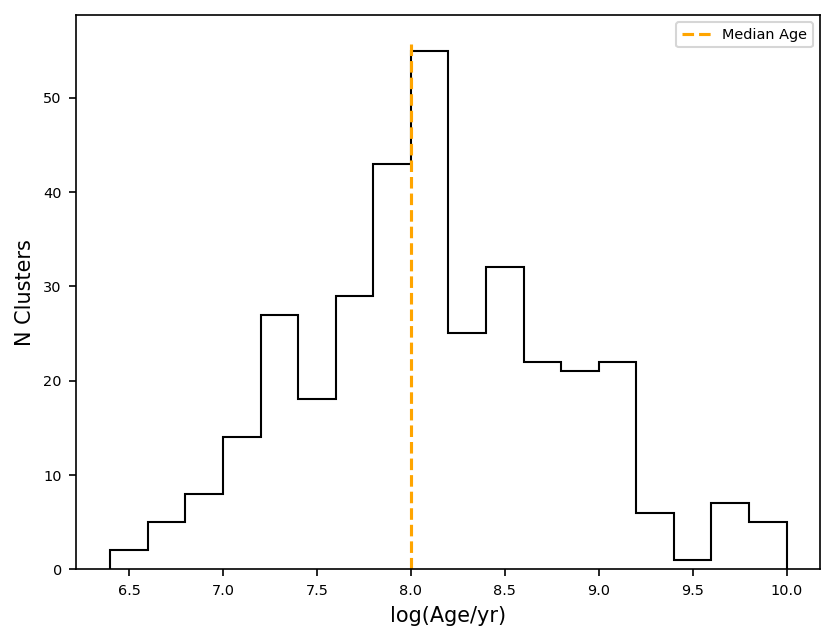

In [69]:
plt.hist(sector_stitched['Lit_Clst_Age'], bins=np.arange(6.4,10.2, .2), histtype='step', color='k')
plt.vlines(x=8.0, ymin=0, ymax=56, linestyle='--', color='orange', label='Median Age')
plt.xlabel('log(Age/yr)')
plt.ylabel('N Clusters')
plt.legend()
plt.savefig('Age_Dist.pdf', bbox_inches='tight', format='pdf')

In [6]:
labels = ['Young', 'Old']
features=['rms', 'std','MAD','sigmaG','skewness','von_neumann_ratio','J_Stetson','max_power','freq_at_max_power',
          'ratio_of_power_at_high_v_low_freq','max_autocorrelation','time_of_max_autocorrelation', 'SumLSP_10_7_Day_Power',
          'SumLSP_7_4_Day_Power','SumLSP_4_1_Day_Power','SumLSP_1_p5_Day_Power', 'Entropy']
len(features)

17

In [11]:
def get_samples(data):
        # Define the range and size of the selection
        
    grouped=data.group_by('name')
    
    low = 0
    high = len(grouped.groups)  # Adjust this as needed
    size = 45  # Number of unique random numbers you want in each set

    # Generate the full range of possible numbers
    possible_numbers = np.arange(low, high)

    # Select the first set of numbers without replacement
    Test_ints = np.random.choice(possible_numbers, size=size, replace=False)

    Training_ints = np.setdiff1d(possible_numbers, Test_ints)
    
    training_data_l=[]
    test_data_l=[]

    for i in range(len(Training_ints)):
        training_data_l.append(grouped.groups[Training_ints[i]])

    training_data = vstack(training_data_l)


    for i in range(len(Test_ints)):
        test_data_l.append(grouped.groups[Test_ints[i]])


    test_data = vstack(test_data_l)

    X_train=np.zeros((len(training_data), len(training_data.colnames)-4))

    for i in range(len(training_data)):
        X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i]    

    X_test=np.zeros((len(test_data), len(test_data.colnames)-4))

    for i in range(len(test_data)):
        X_test[i]= test_data['rms'][i], test_data['std'][i], test_data['MAD'][i], test_data['sigmaG'][i], test_data['skewness'][i], test_data['von_neumann_ratio'][i], test_data['J_Stetson'][i], test_data['max_power'][i], test_data['freq_at_max_power'][i], test_data['ratio_of_power_at_high_v_low_freq'][i], test_data['max_autocorrelation'][i], test_data['time_of_max_autocorrelation'][i], test_data['SumLSP_10_7_Day_Power'][i], test_data['SumLSP_7_4_Day_Power'][i], test_data['SumLSP_4_1_Day_Power'][i], test_data['SumLSP_1_p5_Day_Power'][i], test_data['Entropy'][i]    

    y_train=np.zeros((len(training_data)))

    for i in range(len(training_data)):
        if training_data['Lit_Clst_Age'][i] < np.median(training_data['Lit_Clst_Age']):
            y_train[i]=0
        else:
            y_train[i]=1   
            
    y_test=np.zeros((len(test_data)))

    for i in range(len(test_data)):
        if test_data['Lit_Clst_Age'][i] < np.median(test_data['Lit_Clst_Age']):
            y_test[i]=0
        else:
            y_test[i]=1

    return X_train, X_test, y_train, y_test

In [19]:
def run_evaluate_model(X_train, X_test, y_train, y_test):
    forest = RandomForestClassifier(random_state=0, n_estimators=100)
    forest.fit(X_train, y_train)

    y_pred = forest.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    return recall, precision, forest.feature_importances_



In [15]:
def Run_all(data):
    X_train, X_test, y_train, y_test = get_samples(data)
    
    recall, precision, feat_impotance = run_evaluate_model(X_train, X_test, y_train, y_test)
    
    return recall, precision, feat_impotance

In [20]:
Run_all(data)

/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

(0.5879745081740094,
 0.9447907390917186,
 array([0.04097817, 0.10193541, 0.09007665, 0.08610122, 0.00027919,
        0.05975575, 0.09645497, 0.05075725, 0.07688113, 0.10997203,
        0.04067254, 0.0361297 , 0.03374435, 0.03609157, 0.05186959,
        0.05961637, 0.02868411]))

In [21]:
n_trials=100

recall_results=np.zeros(n_trials)
precission_results=np.zeros(n_trials)

feature_importance= np.zeros((n_trials, len(features)))

for i in range(n_trials):
    print(i)
    recall_results[i], precission_results[i], feature_importance[i] = Run_all(data)

0


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

1


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

2


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

3


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

4


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

5


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

6


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

7


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

8


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

9


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

10


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

11


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

12


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

13


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

14


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

15


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

16


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

17


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

18


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

19


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

20


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

21


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

22


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

23


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

24


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

25


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

26


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

27


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

28


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

29


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

30


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

31


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

32


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

33


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

34


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

35


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

36


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

37


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

38


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

39


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

40


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

41


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

42


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

43


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

44


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

45


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

46


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

47


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

48


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

49


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

50


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

51


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

52


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

53


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

54


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

55


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

56


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

57


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

58


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

59


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

60


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

61


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

62


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

63


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

64


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

65


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

66


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

67


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

68


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

69


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

70


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

71


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

72


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

73


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

74


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

75


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

76


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

77


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

78


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

79


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

80


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

81


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

82


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

83


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

84


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

85


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

86


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

87


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

88


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

89


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

90


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

91


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

92


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

93


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

94


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

95


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

96


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

97


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

98


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

99


/var/folders/gy/0vj93nbd4x5bt_bpj2r46w7h0000gn/T/ipykernel_37451/2431407854.py:36: DeprecationWarning: setting an array element with a sequence. This was supported in some cases where the elements are arrays with a single element. For example `np.array([1, np.array([2])], dtype=int)`. In the future this will raise the same ValueError as `np.array([1, [2]], dtype=int)`.
  X_train[i]= training_data['rms'][i], training_data['std'][i], training_data['MAD'][i], training_data['sigmaG'][i], training_data['skewness'][i], training_data['von_neumann_ratio'][i], training_data['J_Stetson'][i], training_data['max_power'][i], training_data['freq_at_max_power'][i], training_data['ratio_of_power_at_high_v_low_freq'][i], training_data['max_autocorrelation'][i], training_data['time_of_max_autocorrelation'][i], training_data['SumLSP_10_7_Day_Power'][i], training_data['SumLSP_7_4_Day_Power'][i], training_data['SumLSP_4_1_Day_Power'][i], training_data['SumLSP_1_p5_Day_Power'][i], training_data['Entropy'][i

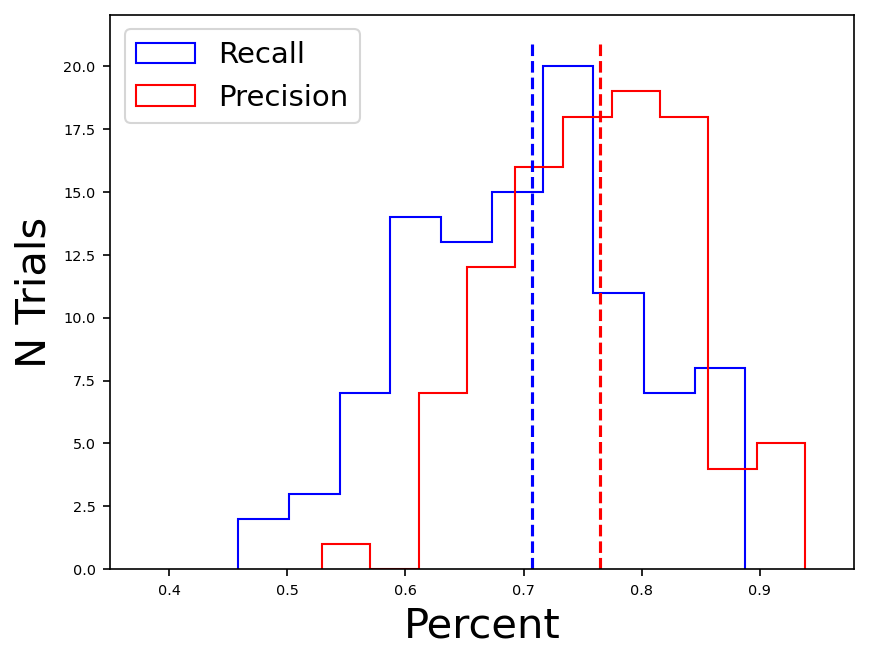

In [32]:
plt.hist(recall_results, bins=10, histtype='step', color='b', label='Recall')
plt.hist(precission_results, bins=10, histtype='step', color='r', label='Precision')
plt.vlines(x=np.median(recall_results), ymin=0, ymax=21, linestyle='--', color='b')
plt.vlines(x=np.median(precission_results), ymin=0, ymax=21, linestyle='--', color='r')
plt.ylabel('N Trials', fontsize=20)
plt.xlabel('Percent', fontsize=20)
plt.legend(fontsize=14)
plt.xlim(0.35, 0.98)
plt.savefig('Dist_for_RF.pdf', bbox_inches='tight', format='pdf')

In [23]:
np.percentile(recall_results, [16,50,84])

array([0.6085727 , 0.70722712, 0.79609446])

In [24]:
np.percentile(precission_results, [16,50,84])

array([0.68267783, 0.76500665, 0.8322658 ])

In [28]:
np.percentile(recall_results, [50]) - np.percentile(recall_results, [16])

array([0.09865442])

In [29]:
np.percentile(recall_results, [84]) - np.percentile(recall_results, [50])

array([0.08886734])

In [30]:
np.percentile(precission_results, [50]) - np.percentile(precission_results, [16])

array([0.08232882])

In [31]:
np.percentile(precission_results, [84]) - np.percentile(precission_results, [50])

array([0.06725915])

In [44]:
np.percentile(feature_importance[:,2], [16,50,84])

array([0.08617535, 0.09335642, 0.09841831])

In [47]:
feature_err=np.zeros(len(features))

for i in range(len(features)):
    feature_err[i] = (np.percentile(feature_importance[:,i], [84]) - np.percentile(feature_importance[:,i], [16]) / 2)
    
feature_err

array([0.02288259, 0.06386375, 0.05533063, 0.05543172, 0.00028744,
       0.03286739, 0.05403985, 0.03016056, 0.03901736, 0.06035301,
       0.02170217, 0.02072973, 0.01861011, 0.01995227, 0.03432607,
       0.03607678, 0.01577784])

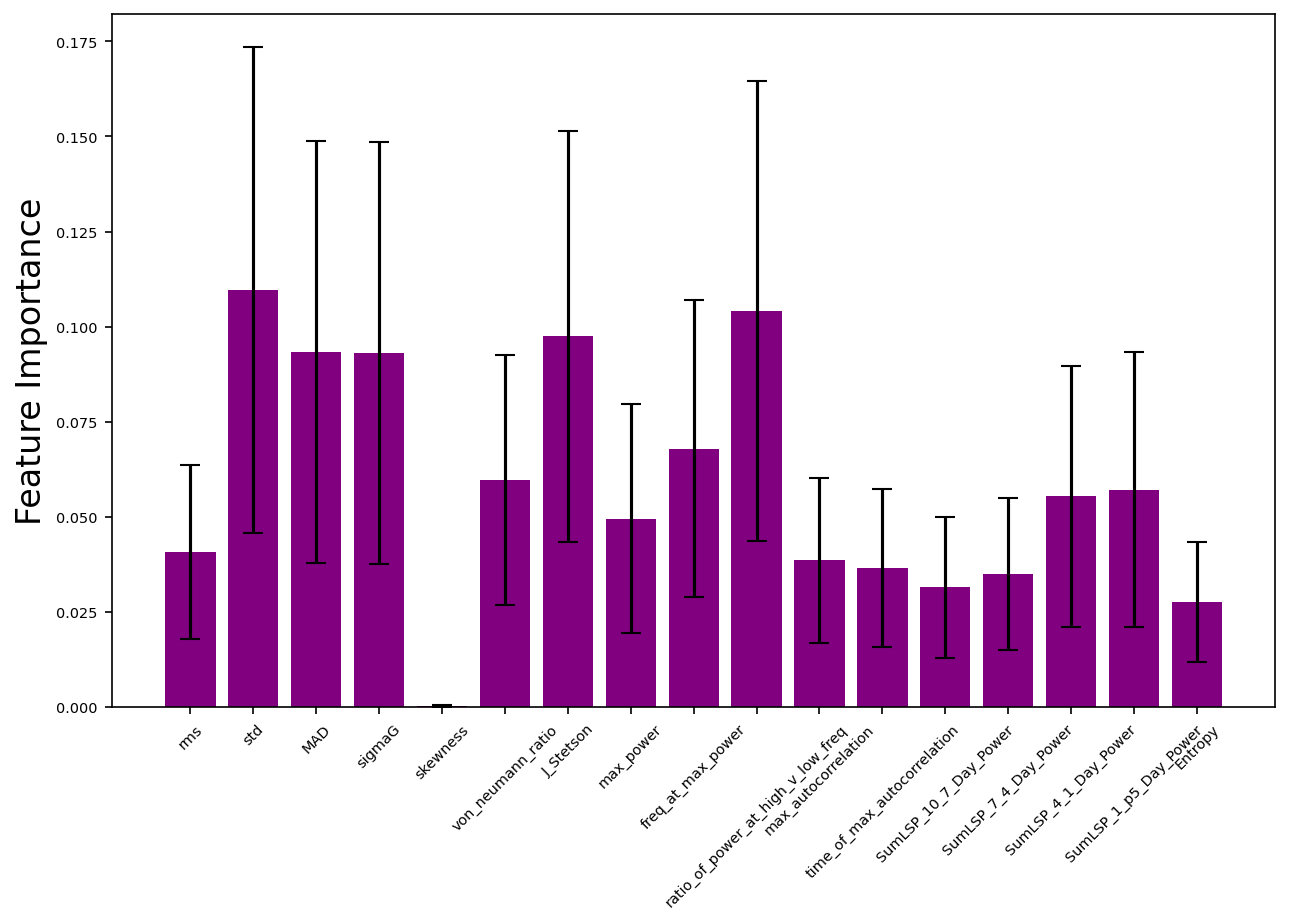

In [52]:
plt.figure(figsize=[10,6])
plt.bar(features, np.median(feature_importance, axis=0), color='purple', yerr=feature_err, capsize=5,  )
plt.xticks(rotation=45 )
plt.ylabel('Feature Importance', fontsize='16')
plt.savefig('RF_Feature_Importance.pdf', bbox_inches='tight', format='pdf')